# Demo of SALT() model

This notebook is meant to give you a quick overview how to use the `SALT()` Python class to compute
the losses in annual energy production (AEP), rotor power, $C_P,$ and thrust coefficients, $C_T$, caused by leading edge roughness (LER) aerodynamic performance degradation. 

This notebook reproduces the results of the spreadsheet version of SALT.

### Preamble

In [1]:
# uncomment the next two lines if you doing development
# %load_ext autoreload
# %autoreload 2
import matplotlib.pylab as plt
import numpy as np

### Import model 
If  you installed the package you can import it as `salt.main.<>`, here we use relative importing which only works as the notebook is in the same folder as the main. 

Import the main class, which contains all methods needed to calculate the losses

In [2]:
from main import SALT

To compute the AEP you need some information about the wind climate, which here is done through a site class that can easily be replaced by your own site definition. It is also possible to change the relationship between thrust cofficient and induction. Note that these classes are copies from [PyWake](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake). 

In [3]:
from auxiliary import UniformWeibullSite, ct2a_mom1d

### Setup

#### Blade clean aerodynamic performance 
Specify the blade lift-to-drag ratio distribution. Each row is another control point. Here the same stepwise definition is used as in the spreadsheet, one could of course build a smooth distribution from a BEM model, by estimating the performance of the blade around the design point. Outside the $r/R$ range speficied the closest value is takem.  

In [8]:
# columns: r/R | clcd | clrat
r_clcd = np.array([[.29, 6.],
                   [.3, 78.],
                   [.69, 78.],
                   [.7, 110.]])

#### Site

In [9]:
weibull_k = 2.       # [-]
weibull_A = 8.       # [m/s]
air_density = 1.225  # [kg/m^3]
site = UniformWeibullSite(weibull_k, weibull_A, air_density=air_density)

#### SALT initilisation

To complete the setup you also need to provide the rated power and radius of the rotor. There are also a number of optional parameters you might want to adjust if you know more about the rotor and its operation. 

In [93]:
rated_power = 2000e3  # [W]
radius = 45.          # [m]

loss = SALT(rated_power, radius, site,
            cutin_ws=3., cutout_ws=25., dws=1.0,
            r_clcd=r_clcd, name='SALT Example',
            max_tip_speed=80., optimum_tsr=9., drivetrain_eff=0.94, n_blades=3,
            ct_inv=8. / 9., cp_opt=16. / 27., cl_design=1.13,
            ct2a=ct2a_mom1d)

#### Blade LER definition

To calculate the losses you need to provide the ratio between aerodynamic performance with LER to clean along each blade. Here it needs to be provided in terms of lift-to-drag, i.e. $(L/D)_{LER} / (L/D)_{clean}$.

The expected input is an array with four columns and $N+1$ rows, where $N$ is the number of blade sections:

0. Normalised radial position of blade section edges, $r/R$
1. L/D fraction per section for blade #0
2. L/D fraction per section for blade #1
3. L/D fraction per section for blade #2

Note that hence the last row of L/D can be kept empty, as it is unused. 

In the spreadsheet the LER blade distribution is defined in terms of aerodynamic categories in alphabetic order from *a* to *e*, from lowest to highest LER impact. The categories are translated into $L/D$ factors using a certain conversion key. Whilst this conversion is derived from measurements, it is preliminary, and might experience major updates following the outcomes of the [LERCat project](https://www.linkedin.com/company/lercateu). Hence ``SALT()`` takes only the L/D fraction as input and you may use any mapping you like to get those.  

Here we demonstrate how the mapping can be done using the same conversion as in the spreadsheet. The LER definition was stored seperately in a CSV file to facilitate reading it in.  

In [28]:
import pandas as pd

# read the csv file into a DataFrame
df = pd.read_csv('damage_input.csv', header=[0, 1])

In [27]:
df

Unnamed: 0_level_0 Unnamed: 1_level_0  Blade 1  Blade 2  Blade 3  \
                  r/R                  r Category Category Category   
0                0.00                0.0        a        a        a   
1                0.30               13.5        a        a        a   
2                0.32               14.4        a        a        a   
3                0.34               15.3        a        a        a   
4                0.36               16.2        a        a        a   
5                0.38               17.1        a        a        a   
6                0.40               18.0        a        a        a   
7                0.42               18.9        a        a        a   
8                0.44               19.8        a        a        a   
9                0.46               20.7        a        a        a   
10               0.48               21.6        a        a        a   
11               0.50               22.5        a        a        a   
12               0.52               23.4        a        a        a   
13               0.54               24.3        a        a        a   
14               0.56               25.2        a        a        a   
15               0.58               26.1        a        a        a   
16               0.60               27.0        a        a        a   
17               0.62               27.9        a        a        a   
18               0.64               28.8        a        a        a   
19               0.66               29.7        a        a        a   
20               0.68               30.6        a        a        a   
21               0.70               31.5        a        a        a   
22               0.72               32.4        a        a        b   
23               0.74               33.3        c        a        b   
24               0.76               34.2        a        b        b   
25               0.78               35.1        a        b        a   
26               0.80               36.0        a        a        a   
27               0.82               36.9        c        a        d   
28               0.84               37.8        c        a        d   
29               0.86               38.7        e        d        b   
30               0.88               39.6        d        c        b   
31               0.90               40.5        d        c        b   
32               0.92               41.4        d        d        b   
33               0.94               42.3        d        e        c   
34               0.96               43.2        e        e        c   
35               0.98               44.1        e        e        e   
36               1.00               45.0      NaN      NaN      NaN   

        Blade 1      Blade 2      Blade 3  
   cl/cd-factor cl/cd-factor cl/cd-factor  
0           1.0          1.0          1.0  
1           1.0          1.0          1.0  
2           1.0          1.0          1.0  
3           1.0          1.0          1.0  
4           1.0          1.0          1.0  
5           1.0          1.0          1.0  
6           1.0          1.0          1.0  
7           1.0          1.0          1.0  
8           1.0          1.0          1.0  
9           1.0          1.0          1.0  
10          1.0          1.0          1.0  
11          1.0          1.0          1.0  
12          1.0          1.0          1.0  
13          1.0          1.0          1.0  
14          1.0          1.0          1.0  
15          1.0          1.0          1.0  
16          1.0          1.0          1.0  
17          1.0          1.0          1.0  
18          1.0          1.0          1.0  
19          1.0          1.0          1.0  
20          1.0          1.0          1.0  
21          1.0          1.0          1.0  
22          1.0          1.0          0.9  
23          0.7          1.0          0.9  
24          1.0          0.9          0.9  
25          1.0          0.9          1.0  
2

In the CSV we already have the L/D factors, but one could remap them.  

We can use the same mapping and check if it is identical:

In [29]:
categories = {'a': 1.0, 'b': 0.9, 'c': 0.7, 'd': 0.5, 'e': 0.3}
df.replace(categories, inplace=True)

In [30]:
df

Unnamed: 0_level_0 Unnamed: 1_level_0  Blade 1  Blade 2  Blade 3  \
                  r/R                  r Category Category Category   
0                0.00                0.0      1.0      1.0      1.0   
1                0.30               13.5      1.0      1.0      1.0   
2                0.32               14.4      1.0      1.0      1.0   
3                0.34               15.3      1.0      1.0      1.0   
4                0.36               16.2      1.0      1.0      1.0   
5                0.38               17.1      1.0      1.0      1.0   
6                0.40               18.0      1.0      1.0      1.0   
7                0.42               18.9      1.0      1.0      1.0   
8                0.44               19.8      1.0      1.0      1.0   
9                0.46               20.7      1.0      1.0      1.0   
10               0.48               21.6      1.0      1.0      1.0   
11               0.50               22.5      1.0      1.0      1.0   
12               0.52               23.4      1.0      1.0      1.0   
13               0.54               24.3      1.0      1.0      1.0   
14               0.56               25.2      1.0      1.0      1.0   
15               0.58               26.1      1.0      1.0      1.0   
16               0.60               27.0      1.0      1.0      1.0   
17               0.62               27.9      1.0      1.0      1.0   
18               0.64               28.8      1.0      1.0      1.0   
19               0.66               29.7      1.0      1.0      1.0   
20               0.68               30.6      1.0      1.0      1.0   
21               0.70               31.5      1.0      1.0      1.0   
22               0.72               32.4      1.0      1.0      0.9   
23               0.74               33.3      0.7      1.0      0.9   
24               0.76               34.2      1.0      0.9      0.9   
25               0.78               35.1      1.0      0.9      1.0   
26               0.80               36.0      1.0      1.0      1.0   
27               0.82               36.9      0.7      1.0      0.5   
28               0.84               37.8      0.7      1.0      0.5   
29               0.86               38.7      0.3      0.5      0.9   
30               0.88               39.6      0.5      0.7      0.9   
31               0.90               40.5      0.5      0.7      0.9   
32               0.92               41.4      0.5      0.5      0.9   
33               0.94               42.3      0.5      0.3      0.7   
34               0.96               43.2      0.3      0.3      0.7   
35               0.98               44.1      0.3      0.3      0.3   
36               1.00               45.0      NaN      NaN      NaN   

        Blade 1      Blade 2      Blade 3  
   cl/cd-factor cl/cd-factor cl/cd-factor  
0           1.0          1.0          1.0  
1           1.0          1.0          1.0  
2           1.0          1.0          1.0  
3           1.0          1.0          1.0  
4           1.0          1.0          1.0  
5           1.0          1.0          1.0  
6           1.0          1.0          1.0  
7           1.0          1.0          1.0  
8           1.0          1.0          1.0  
9           1.0          1.0          1.0  
10          1.0          1.0          1.0  
11          1.0          1.0          1.0  
12          1.0          1.0          1.0  
13          1.0          1.0          1.0  
14          1.0          1.0          1.0  
15          1.0          1.0          1.0  
16          1.0          1.0          1.0  
17          1.0          1.0          1.0  
18          1.0          1.0          1.0  
19          1.0          1.0          1.0  
20          1.0          1.0          1.0  
21          1.0          1.0          1.0  
22          1.0          1.0          0.9  
23          0.7          1.0          0.9  
24          1.0          0.9          0.9  
25          1.0          0.9          1.0  
2

As mentioned you can implement any mapping or categories you like.

Now let's build the LER input distribution:

In [34]:
r_fclcd_ler = df.iloc[:, [0, 2, 3, 4]].to_numpy()
print(r_fclcd_ler)

[[0.   1.   1.   1.  ]
 [0.3  1.   1.   1.  ]
 [0.32 1.   1.   1.  ]
 [0.34 1.   1.   1.  ]
 [0.36 1.   1.   1.  ]
 [0.38 1.   1.   1.  ]
 [0.4  1.   1.   1.  ]
 [0.42 1.   1.   1.  ]
 [0.44 1.   1.   1.  ]
 [0.46 1.   1.   1.  ]
 [0.48 1.   1.   1.  ]
 [0.5  1.   1.   1.  ]
 [0.52 1.   1.   1.  ]
 [0.54 1.   1.   1.  ]
 [0.56 1.   1.   1.  ]
 [0.58 1.   1.   1.  ]
 [0.6  1.   1.   1.  ]
 [0.62 1.   1.   1.  ]
 [0.64 1.   1.   1.  ]
 [0.66 1.   1.   1.  ]
 [0.68 1.   1.   1.  ]
 [0.7  1.   1.   1.  ]
 [0.72 1.   1.   0.9 ]
 [0.74 0.7  1.   0.9 ]
 [0.76 1.   0.9  0.9 ]
 [0.78 1.   0.9  1.  ]
 [0.8  1.   1.   1.  ]
 [0.82 0.7  1.   0.5 ]
 [0.84 0.7  1.   0.5 ]
 [0.86 0.3  0.5  0.9 ]
 [0.88 0.5  0.7  0.9 ]
 [0.9  0.5  0.7  0.9 ]
 [0.92 0.5  0.5  0.9 ]
 [0.94 0.5  0.3  0.7 ]
 [0.96 0.3  0.3  0.7 ]
 [0.98 0.3  0.3  0.3 ]
 [1.    nan  nan  nan]]


### Simulation

Now you can just call the class with the distribution and you will get the AEP loss. There are also a number of other outputs which are simply stored in the class. Have a look the docstring for an entire list. Note that the radial resolution of the LER distribution has an influence on the result as it defines the resolution of the simplified BEM model underlying the computation. 

In [94]:
loss(r_fclcd_ler)

print('AEP loss: {:.2f} %'.format(loss.rel_aep_loss * 1e2))

AEP loss: 2.08 %


### Plotting

There are some in-build plotting tools available as well.

(<Axes: title={'center': 'SALTexample: Power loss'}, xlabel='V [m/s]', ylabel='Power loss [%]'>,
 <Figure size 680x510 with 1 Axes>)

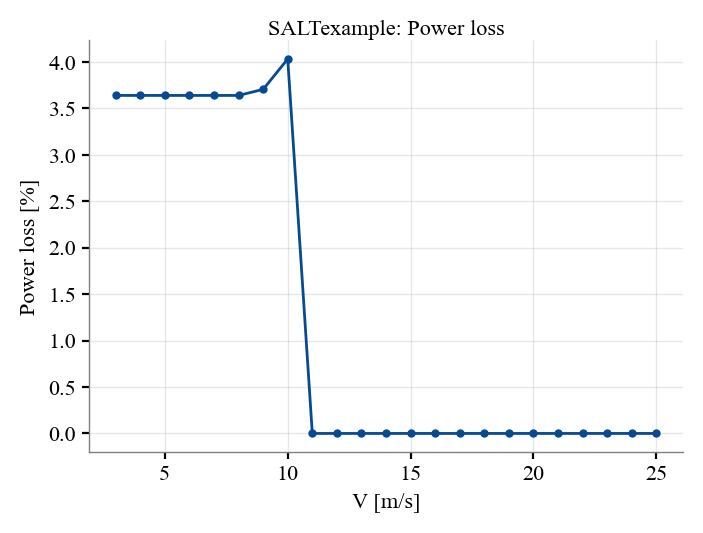

In [89]:
loss.plot_power_loss()

(<Axes: title={'center': 'SALTexample: L/D distributions'}, xlabel='Normalised radius, $r/R$ [-]', ylabel='Lift-to-drag ratio, $L/D$ [-]'>,
 <Figure size 680x510 with 1 Axes>)

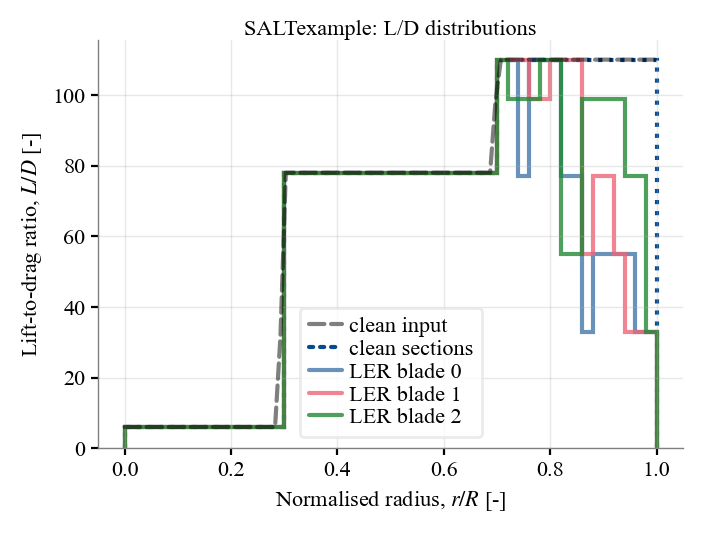

In [79]:
loss.plot_clcd()

(<Axes: title={'center': 'SALTexample: L/D distributions'}, xlabel='Normalised radius, $r/R$ [-]', ylabel='LER lift factor [-]'>,
 <Figure size 680x510 with 1 Axes>)

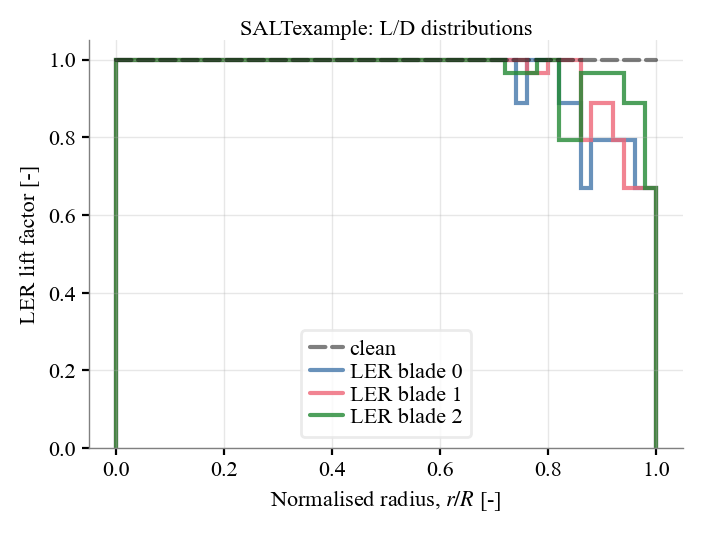

In [97]:
loss.plot_clrat()

(<Axes: title={'center': 'SALTexample: Tip-speed-ratio'}, xlabel='Wind speed, [m/s]', ylabel='Tip-speed-ratio, $\\lambda$ [-]'>,
 <Figure size 680x510 with 1 Axes>)

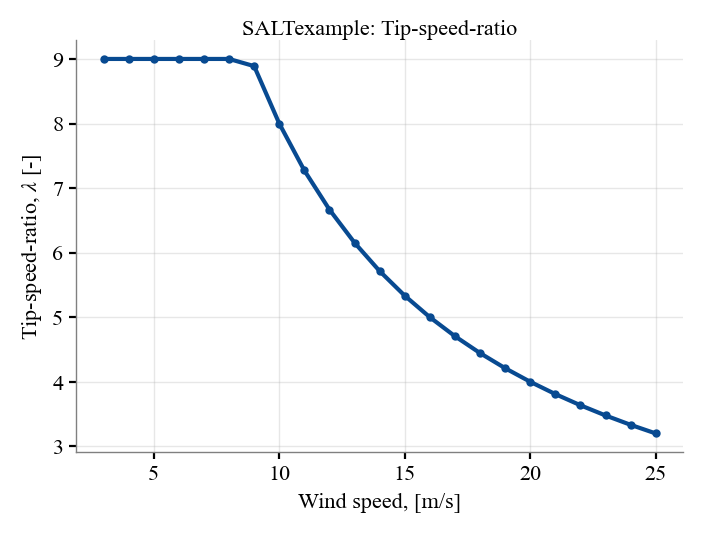

In [81]:
loss.plot_tsr()


(<Axes: title={'center': 'SALTexample: Power coefficient'}, xlabel='V [m/s]', ylabel='$C_p$ [-]'>,
 <Figure size 680x510 with 1 Axes>)

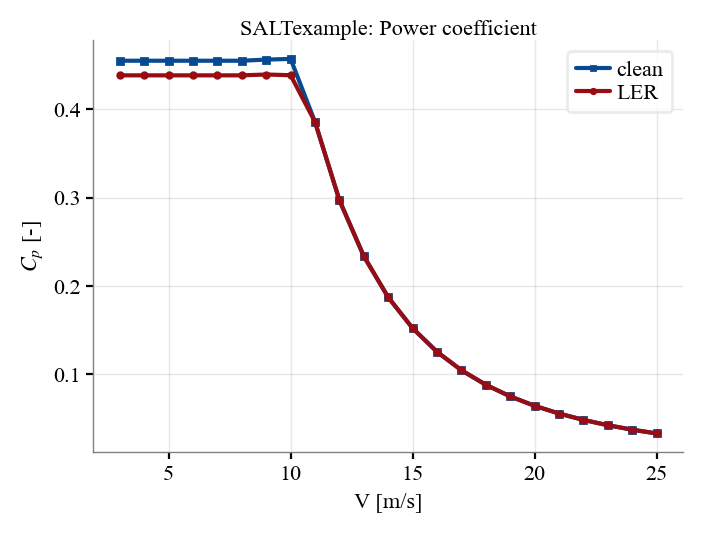

In [84]:
loss.plot_cp()

(<Axes: title={'center': 'SALTexample: Thrust coefficient'}, xlabel='V [m/s]', ylabel='$C_T$ [-]'>,
 <Figure size 680x510 with 1 Axes>)

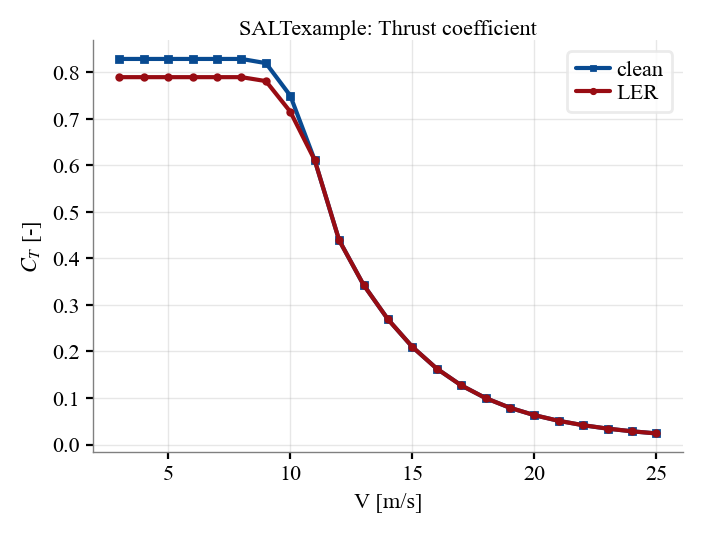

In [85]:
loss.plot_ct()

(<Axes: title={'center': 'SALTexample: Power'}, xlabel='V [m/s]', ylabel='Power [MW]'>,
 <Figure size 680x510 with 1 Axes>)

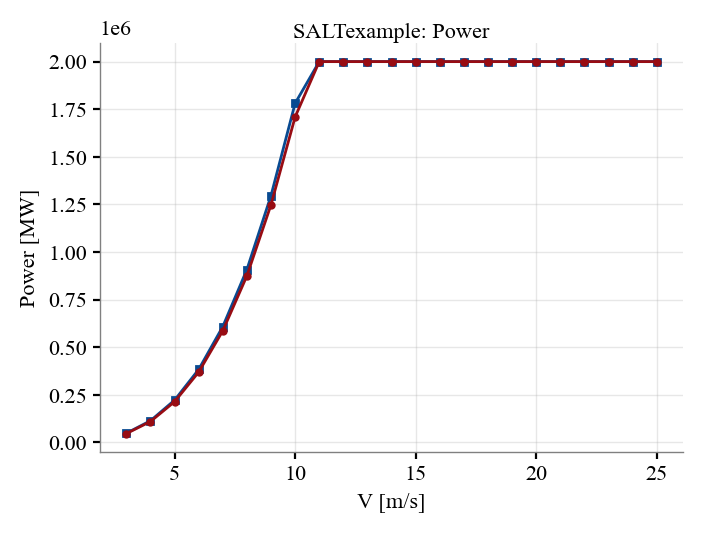

In [86]:
loss.plot_power()

(<Axes: title={'center': 'Weibull distribution: k=2.0, A=8.0m/s'}, xlabel='V [m/s]', ylabel='$w$ [-]'>,
 <Figure size 680x510 with 2 Axes>)

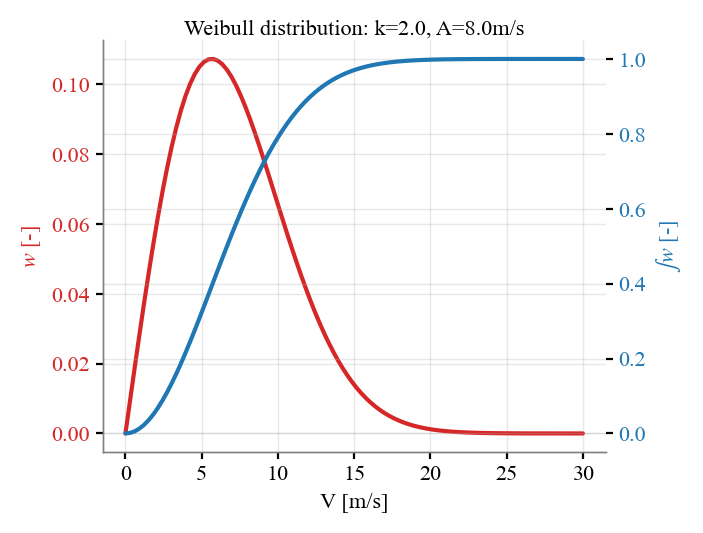

In [96]:
site.plot_weibull()